In [1]:
import os.path as osp
import sys
sys.path.insert(0,'../../')


from latent_3d_points.src.ae_templates import mlp_architecture_ala_iclr_18, default_train_params
from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.point_net_ae import PointNetAutoEncoder

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from latent_3d_points.src.tf_utils import reset_tf_graph
from latent_3d_points.src.general_utils import plot_3d_point_cloud

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
top_out_dir = '../data/'          # Use to save Neural-Net check-points etc.
top_in_dir = '../data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

experiment_name = 'single_class_ae'
n_pc_points = 2048                # Number of points per model.
bneck_size = 128                  # Bottleneck-AE size
ae_loss = 'chamfer'                   # Loss to optimize: 'emd' or 'chamfer'
class_name = raw_input('Give me the class name (e.g. "chair"): ').lower()

Give me the class name (e.g. "chair"): chair


In [4]:
syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir , syn_id)
all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)

6778 pclouds were loaded. They belong in 1 shape-classes.


In [5]:
train_dir = osp.join(top_out_dir, experiment_name)
load_pre_trained_ae = True
restore_epoch = 500
if load_pre_trained_ae:
    conf = Conf.load(train_dir + '/configuration')
    reset_tf_graph()
    ae = PointNetAutoEncoder(conf.experiment_name, conf)
    ae.restore_model(conf.train_dir, epoch=restore_epoch)

Building Encoder
encoder_conv_layer_0 conv params =  256 bnorm params =  128
Tensor("single_class_ae_2/Relu:0", shape=(?, 2048, 64), dtype=float32)
output size: 131072 

encoder_conv_layer_1 conv params =  8320 bnorm params =  256
Tensor("single_class_ae_2/Relu_1:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_2 conv params =  16512 bnorm params =  256
Tensor("single_class_ae_2/Relu_2:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_3 conv params =  33024 bnorm params =  512
Tensor("single_class_ae_2/Relu_3:0", shape=(?, 2048, 256), dtype=float32)
output size: 524288 

encoder_conv_layer_4 conv params =  32896 bnorm params =  256
Tensor("single_class_ae_2/Relu_4:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

Tensor("single_class_ae_2/Max:0", shape=(?, 128), dtype=float32)
Building Decoder
decoder_fc_0 FC params =  33024 Tensor("single_class_ae_2/Relu_5:0", shape=(?, 256), dtype=float32)
output size: 256 

In [6]:
feed_pc, feed_model_names, _ = all_pc_data.next_batch(10)
# reconstructions = ae.reconstruct(feed_pc)[0]
# latent_codes = ae.transform(feed_pc)

In [7]:
print feed_pc.shape

(10, 2048, 3)


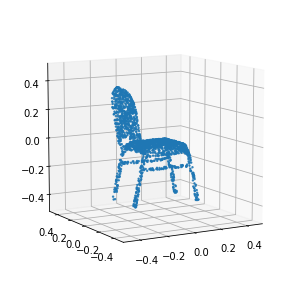

In [8]:
i = 9
plot_3d_point_cloud(feed_pc[i][:, 0], 
                    feed_pc[i][:, 1], 
                    feed_pc[i][:, 2], in_u_sphere=True);

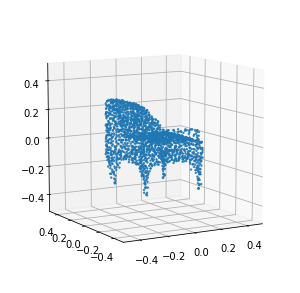

In [9]:
import numpy as np
new_latent_codes = ae.get_latent_codes(feed_pc)
new_decodes = ae.decode(new_latent_codes)
interp_points = ae.interpolate(np.squeeze(new_decodes[0,:,:]), np.squeeze(new_decodes[4,:,:]),10)
j = 6
plot_3d_point_cloud(interp_points[j][:, 0], 
                    interp_points[j][:, 1], 
                    interp_points[j][:, 2], in_u_sphere=True);

In [10]:
print np.expand_dims(feed_pc[0,:,:],axis=0).shape
print interp_points[6,:,:].shape
grad = ae.gradient_of_input_wrt_loss(np.expand_dims(feed_pc[0,:,:],axis=0), np.expand_dims(interp_points[6,:,:],axis=0))

(1, 2048, 3)
(2048, 3)


In [11]:
print np.asarray(grad)

[[[[-1.0027259e-05  1.0648226e-05 -3.0906522e-06]
   [ 1.2834218e-05 -4.8044603e-06  5.5765122e-07]
   [-6.4727647e-06 -9.4855204e-06  9.5288851e-07]
   ...
   [ 4.5493507e-06 -1.5343614e-05  3.0775991e-06]
   [-2.0180014e-05 -1.6270438e-05 -1.2748860e-06]
   [ 7.0041278e-07  1.8724751e-05 -2.1398882e-06]]]]


In [12]:
def decoder_gradient_wrt_codes(ae_in ,in_code, gt_points):
    return ae_in.sess.run(tf.gradients(ae_in.loss, ae_in.z), feed_dict={ae_in.z: in_code, ae.gt: gt_points})
    

In [13]:
def grad_descent(x_in, grad, gamma):
    x_out = x_in - gamma*grad
    return x_out

In [42]:
sys.path.append('../../pointnet2/utils/')
import pc_util
import tensorflow as tf

x_in = np.expand_dims(feed_pc[0,:,:],axis=0)
x_target = np.expand_dims(interp_points[6,:,:],axis=0)
print x_target.shape
target_n_points = x_target.shape[1]

desired_n_samples = 1000

choice_idx = np.random.choice(target_n_points, desired_n_samples, replace=False)
repeat_idx = np.random.choice(target_n_points, 1, replace=False)

tmp = np.squeeze(x_target) - x_target[0,repeat_idx,:]
tmp = np.linalg.norm(tmp, axis=1)

tmp = np.where(tmp < 0.3)[0]

print tmp.shape

desired_n_samples = tmp.shape[0]

chosen_points  = np.expand_dims(x_target[0,choice_idx, :], axis=0)
repeated_points = np.expand_dims(np.repeat(x_target[0,repeat_idx,:], 2048-desired_n_samples, axis=0), axis=0)

chosen_points = np.expand_dims(x_target[0,tmp, :], axis=0)
new_target = np.hstack((chosen_points, repeated_points))
print new_target.shape
# new_target = np.vstack(x_target[1,choice_idx, :], np.repeat(x_target[1,repeat_idx,:], 2048-desired_n_samples, axis=0))

(1, 2048, 3)
(959,)
(1, 2048, 3)


In [43]:
points_list = []



x_in_code = ae.get_latent_codes(x_in)
# x_target_code = ae.get_latent_codes(x_target)
points_list.append(x_in_code)



new_code = x_in_code

pc_util.write_ply(np.squeeze(ae.decode(new_code)), './noisy/input0.ply')
pc_util.write_ply(np.squeeze(new_target), './noisy/gt0.ply')


print new_code

# print np.asarray(grad).shape

# grad = ae.gradient_of_input_wrt_loss(x_in, x_target)
for j in xrange(10):
    grad = decoder_gradient_wrt_codes(ae, new_code, new_target)
    grad = np.expand_dims(np.squeeze(grad),axis=0)
    newer_code = grad_descent(new_code, grad, 50)
    new_code = newer_code
    points_list.append(new_code)
    
# points_list.append(x_target_code)

# points_list.append(np.squeeze(ae.decode(new_code))
for j in xrange(11):
    pc_util.write_ply(np.squeeze(ae.decode(points_list[j])), './noisy/input'+str(j)+'.ply')
    
pc_util.write_ply(np.squeeze(new_target), './noisy/input'+str(j+1)+'.ply')

[[0.02498506 0.06778532 0.12060625 0.499382   0.07686763 0.09986036
  0.29013866 0.21913023 0.00584113 0.19553502 0.36506397 0.1765703
  0.45007315 0.11485881 0.0555907  0.24245042 0.00398266 0.40709692
  0.5036187  0.06163071 0.13756298 0.35633075 0.0012112  0.23232129
  0.24592271 0.25301582 0.15298837 0.09978104 0.5818439  0.34983838
  0.20813005 0.04499119 0.02717255 0.33220172 0.330495   0.18386799
  0.11341666 0.02437578 0.04307774 0.04940182 0.572016   0.22581185
  0.17706108 0.39806607 0.17027459 0.1713462  0.2700727  0.24647455
  0.20592217 0.3320863  0.28070948 0.28847533 0.06684512 0.21075079
  0.35356835 0.44005105 0.11639971 0.698141   0.07414765 0.06618292
  0.21263495 0.28761417 0.23876306 0.39794695 0.21194491 0.24014871
  0.07261211 0.24266678 0.1103186  0.20835206 0.25632983 0.3236185
  0.04486256 0.17901456 0.14725146 0.08811955 0.19323891 0.20242795
  0.25300446 0.02904189 0.07827463 0.27822962 0.11029238 0.26659915
  0.03495711 0.14903492 0.0536653  0.24335724 0.24